In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import covasim as cv
from util import data

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


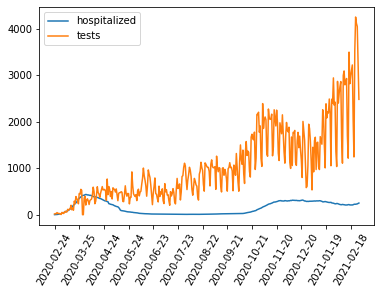

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)

plt.plot(df['hospitalized'], label='hospitalized')
plt.plot(df['tests'], label='tests')
plt.xticks(df.index[::30], rotation=60)
plt.legend()
plt.show()

In [3]:
params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df.index[0],
    end_day=df.index[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    pop_infected=pop_size / 1e3,
    n_beds_hosp=pop_size * 3.18 / 1e3,
    n_beds_icu=pop_size * 12.5 / 100e3
)

In [4]:
# QUAR_POLICY --> test both at the beginning and at the end of the quarantine
# SENTIVITY --> 80% (20% of false negatives: https://www.health.harvard.edu/blog/which-test-is-best-for-covid-19-2020081020734)
# ILI_PREV --> prevalence of influenza-like-illness symptoms in the population
# LOSS_PROB --> probability of the person being lost-to-follow-up (default 0%, i.e. no one lost to follow-up)
# TEST_DELAY --> days for test result to be known (default 0, i.e. results available instantly)

tests_intervention = cv.test_num(
    df['tests'].values,
    quar_policy='both',
    sensitivity=0.8,
    do_plot=False
)

# tests_intervention = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, do_plot=False)

In [5]:
# TRACE_PROBS:
#   100% of household contacts (h)
#   80% of school contacts (s)
#   50% of work contacts (w)
#   0% of casual contacts (c)
# TRACE_TIME:
#   0 days for household contacts (h)
#   2 days for school contacts (h)
#   3 days for work contacts (h)
#   7 days for casual contacts (h)

tracing_intervention = cv.contact_tracing(
    trace_probs=dict(h=1.0, s=0.8, w=0.6, c=0.0),
    trace_time=dict(h=0, s=2, w=3, c=7),
    do_plot=False
)

In [6]:
lockdown_start = (pd.to_datetime('2020-03-08').date() - df.index[0]).days
lockdown_end = (pd.to_datetime('2020-05-18').date() - df.index[0]).days
summer_end = (pd.to_datetime('2020-09-15').date() - df.index[0]).days
orange_zone_1 = (pd.to_datetime('2020-11-15').date() - df.index[0]).days
yellow_zone_1 = (pd.to_datetime('2020-12-10').date() - df.index[0]).days
orange_zone_2 = (pd.to_datetime('2020-12-21').date() - df.index[0]).days
yellow_zone_2 = (pd.to_datetime('2021-02-01').date() - df.index[0]).days

# schools closed from 08/03 to 15/09, then blended modality until orange zone
school_closed_intervention = cv.clip_edges(
    days=[lockdown_start, summer_end, orange_zone_1],
    changes=[0.0, 0.8, 0.6],
    layers='s'
)

# smart working from 08/03 to 18/05
smart_working_intervention = cv.clip_edges(
    days=[lockdown_start, lockdown_end],
    changes=[0.6, 0.9],
    layers='w'
)

# lockdown from 08/03, then no lockdown, then orange/yellow zones
lockdown_intervention = cv.clip_edges(
    days=[lockdown_start, lockdown_end, orange_zone_1, yellow_zone_1, orange_zone_2, yellow_zone_2],
    changes=[0.2, 1.0, 0.6, 0.9, 0.6, 0.9],
    layers='c'
)

# non-compulsory masks from may (but lower transmissibility due to summer), then compulsory masks from september
beta_intervention = cv.change_beta(
    days=[lockdown_end, summer_end],
    changes=[0.2, 0.6],
    layers=['s', 'w', 'c']
)

# regional lockdowns to avoid imported cases
imported_intervention = cv.dynamic_pars(
    n_imports=dict(
        days=[lockdown_start, lockdown_end, orange_zone_1, yellow_zone_1, orange_zone_2, yellow_zone_2],
        vals=[0.1, 2.0, 0.4, 0.8, 0.4, 0.8]
    )
)


In [7]:
interventions = [
    tests_intervention,
    tracing_intervention,
    school_closed_intervention,
    smart_working_intervention,
    lockdown_intervention,
    beta_intervention,
    imported_intervention
]

sim = cv.Sim(pars=params, interventions=interventions)
msim = cv.MultiSim(sim, n_runs=30)
msim.run()

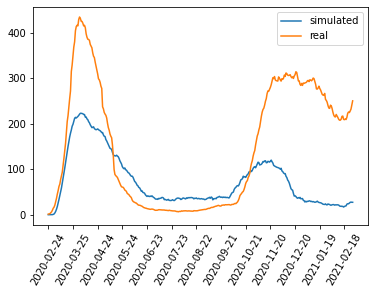

In [9]:
res = [s.results['n_severe'].values + s.results['n_critical'].values for s in msim.sims]
res = pd.Series(data=np.array(res).mean(0), index=df.index)
plt.plot(res, label='simulated')
plt.plot(df['hospitalized'], label='real')
plt.xticks(df.index[::30], rotation=60)
plt.legend()
plt.show()